## 1.Ý tưởng

1. Ban đầu clustering các nhà có chung đặc điểm với nhau thành cụm nhà đắt tiền, nhà giá trung bình, giá ít, rồi tính khoảng cách từ từng tâm (trung bình giá của từng hạng mục) rồi nhân tỷ lệ với giá đó

2. Ý tưởng 2 đó là KNN do những nhà các đặc điểm giống nhau khả năng sẽ có giá giống nhau

3. Mix up 2 cái, phân loại rồi KNN những nhà trong cùng 1 cụm

## 2.Code

Cách 1 K means clustering

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

In [5]:
data_pre_norm = pd.read_csv(r'../data/afterprocessed/processed_pre_norm.csv')
data_pre_norm.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,5,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,4,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486,5,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,4,1,2001.0,1,2,608,4,4,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216,5,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3,642,4,4,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655,5,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,4,1,2000.0,1,3,836,4,4,2,192,84,0,0,0,0,0,12,2008,8,4,250000


In [6]:
data_post_norm = pd.read_csv(r'../data/afterprocessed/processed_post_norm.csv')
data_post_norm.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.073375,-0.045532,-0.226101,-0.207142,0.064238,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,1.050994,0.878668,-0.491516,-0.125797,0.743092,0.751626,-1.241449,0.514104,-0.777976,0.364207,0.835599,-0.339830,0.232937,0.591905,-0.434989,0.575425,0.272847,-0.288653,-0.944591,-0.459303,-0.123046,-0.884658,0.263813,0.301599,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.409369,0.912210,0.255978,-0.951226,0.854650,-0.768736,1.011701,-0.318475,0.311725,0.351000,0.11211,0.0689,0.289745,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.313867,0.208502,208500
1,2,-0.872563,-0.045532,0.455190,-0.091886,0.064238,0.750731,0.314667,-0.02618,-0.628316,-0.225716,1.954302,-1.188074,-0.03174,-0.411691,-0.543457,-0.071836,2.179628,0.156734,-0.429577,-0.491516,-0.125797,-0.508251,-0.661060,0.387047,-0.570750,0.663451,0.364207,-0.549162,-0.339830,0.232937,-1.124444,-1.502357,1.171992,0.272847,-0.288653,-0.641228,0.466465,-0.123046,-0.884658,0.263813,0.301599,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,0.795629,-0.318683,0.255978,0.600495,0.139585,-0.768736,-0.097822,-0.318475,0.311725,-0.060731,0.11211,0.0689,0.289745,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.313867,0.208502,181500
2,3,0.073375,-0.045532,-0.089843,0.073480,0.064238,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,0.984752,0.830215,-0.491516,-0.125797,0.743092,0.751626,-1.241449,0.325915,-0.777976,0.364207,0.835599,-0.339830,0.232937,-0.266269,-0.434989,0.092907,0.272847,-0.288653,-0.301643,-0.313369,-0.123046,-0.884658,0.263813,0.301599,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.409369,-0.318683,0.255978,0.600495,0.139585,-0.768736,0.929514,-0.318475,0.311725,0.631726,0.11211,0.0689,0.289745,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.313867,0.208502,223500
3,4,0.309859,-0.045532,-0.453198,-0.096897,0.064238,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-1.039872,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,-1.863632,-0.720298,-0.491516,-0.125797,1.055928,1.316701,0.387047,-0.570750,0.663451,0.364207,-1.933923,0.772619,-2.724353,0.591905,-1.502357,-0.499274,0.272847,-0.288653,-0.061670,-0.687324,-0.123046,0.265476,0.263813,0.301599,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,-0.409369,0.296763,0.255978,0.600495,-1.290545,1.301075,0.806234,0.801942,1.650307,0.790804,0.11211,0.0689,0.289745,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,140000
4,5,0.073375,-0.045532,0.636868,0.375148,0.064238,-1.378933,0.314667,-0.02618,-0.628316,-0.225716,0.457215,-0.036289,-0.03174,-0.411691,1.026689,1.374795,-0.517200,0.951632,0.733308,-0.491516,-0.125797,0.743092,0.751626,-1.241449,1.366489,-0.777976,0.364207,0.835599,-0.339830,0.232937,-1.982

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_pre_norm.drop('SalePrice', axis=1), data_pre_norm['SalePrice'], test_size=0.2, random_state=42)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(data_post_norm.drop('SalePrice', axis=1), data_post_norm['SalePrice'], test_size=0.2, random_state=42)

Text(0.5, 0, 'Number of clusters')

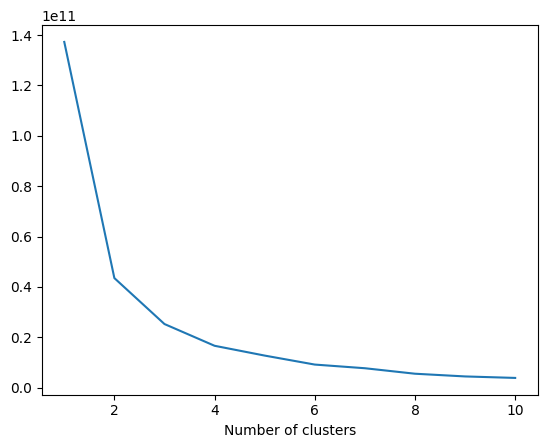

In [101]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss) 
plt.xlabel('Number of clusters') 

Ở đây ra có thể thấy 4 clusters là bắt đầu bão hòa, nên ta chỉ nên thử với 4-5 cluster, tránh overfit

In [109]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(X_train)
mean_price_for_cluster = y_train.groupby(kmeans.labels_).mean()
min_price_for_cluster = y_train.groupby(kmeans.labels_).min()
mean_price_for_cluster = mean_price_for_cluster.values.T
mean_price_for_cluster

array([156841.51150203, 295737.5       , 273965.625     , 221152.67481663])

In [80]:
def price_predictor(X, mean_price_for_cluster):
    label = kmeans.predict(X)
    price_list = []
    for i in range(len(X)):
        # percentage_of_dis = 1 + cdist(X.iloc[i].to_numpy().reshape(1, -1), kmeans.cluster_centers_[label[i]].reshape(1, -1), 'euclidean') / distance_array[label[i]]
        price = mean_price_for_cluster[label[i]] 
        price_list.append(price)
    return np.array(price_list).flatten()
    

In [110]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = price_predictor(X_test, mean_price_for_cluster)
y_pred = pd.Series(y_pred, index=y_test.index)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 6466868335.013641
R2 Score: 0.15689787365833796


In [79]:
y_pred_train = price_predictor(X_train, mean_price_for_cluster)
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
print('Mean Squared Error:', mean_squared_error(y_train, y_pred_train))
print('R2 Score:', r2_score(y_train, y_pred_train))

Mean Squared Error: 4675735754.542287
R2 Score: 0.21607909115821788


Kết luận: K-means centers ko phải lựa chọn hợp lý, dù cho là lấy giá trị trung bình hoặc lấy tỷ lệ của giá trị này so với độ dài

## KNN

In [96]:
def testing(list_of_neighbours,weights):
    for i in list_of_neighbours:
        KNR = KNeighborsRegressor(n_neighbors=i,weights=weights,algorithm='auto',p=2,)
        KNR.fit(X_norm_train, y_norm_train)

        print(f'for {i} number(s) of neighbours the score is: ',KNR.score(X_norm_test, y_norm_test))

In [98]:
testing([2,3,5,7],'uniform')

for 2 number(s) of neighbours the score is:  0.3450981911468618
for 3 number(s) of neighbours the score is:  0.3064551995643866
for 5 number(s) of neighbours the score is:  0.26592583702699124
for 7 number(s) of neighbours the score is:  0.2263544111049537


In [99]:
testing([2,3,5,7],'distance')

for 2 number(s) of neighbours the score is:  0.35003073271295193
for 3 number(s) of neighbours the score is:  0.3183373305139019
for 5 number(s) of neighbours the score is:  0.2827334085993204
for 7 number(s) of neighbours the score is:  0.24569513042634328


Nhận xét: neighbours càng ít, càng ít nhiễu nên đoán được giá càng sát, score này là score R2 tức độ tương quan giữa kết quả đầu ra và giá trị thực

## Decision Tree, Random forest

In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
Regr = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=1, n_jobs=-1)
OneRegr = DecisionTreeRegressor(criterion='squared_error', random_state=1)
Regr.fit(X_train, y_train)
OneRegr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [122]:
Regr.score(X_test, y_test)

0.8940132008879234

In [123]:
OneRegr.score(X_test, y_test)

0.7763731665516105

In [125]:
OneRegr5 = DecisionTreeRegressor(criterion='squared_error', random_state=1,max_depth=5)


[Text(0.5360169491525424, 0.9166666666666666, 'OverallQual <= 7.5\nsquared_error = 5964550379.77\nsamples = 1168\nvalue = 181441.542'),
 Text(0.2711864406779661, 0.75, 'OverallQual <= 6.5\nsquared_error = 2363399388.322\nsamples = 984\nvalue = 158879.154'),
 Text(0.4036016949152542, 0.8333333333333333, 'True  '),
 Text(0.13559322033898305, 0.5833333333333334, 'GrLivArea <= 1378.5\nsquared_error = 1447929508.083\nsamples = 726\nvalue = 142077.643'),
 Text(0.06779661016949153, 0.4166666666666667, 'TotalBsmtSF <= 969.5\nsquared_error = 817629555.813\nsamples = 438\nvalue = 125810.158'),
 Text(0.03389830508474576, 0.25, 'CentralAir <= 0.5\nsquared_error = 602014648.223\nsamples = 267\nvalue = 113133.071'),
 Text(0.01694915254237288, 0.08333333333333333, 'squared_error = 526192058.66\nsamples = 48\nvalue = 87358.417'),
 Text(0.05084745762711865, 0.08333333333333333, 'squared_error = 441112200.68\nsamples = 219\nvalue = 118782.311'),
 Text(0.1016949152542373, 0.25, 'OverallCond <= 4.5\nsquar

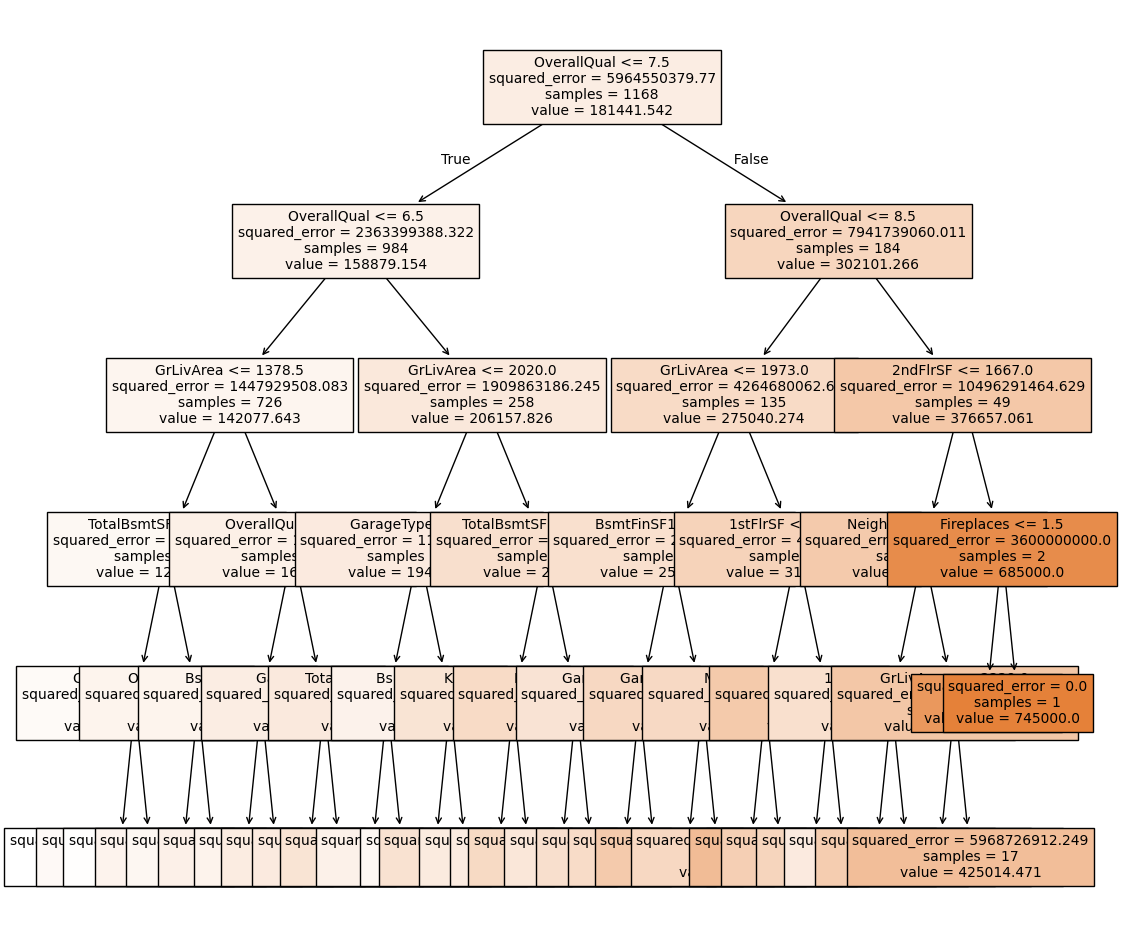

In [131]:
plt.figure(figsize=(12,12))
plot_tree(OneRegr5.fit(X_train, y_train),filled=True,feature_names=X_train.columns,fontsize=10)

[Text(0.7360874011948368, 0.9814814814814815, 'OverallQual <= 7.5\nsquared_error = 5964550379.77\nsamples = 1168\nvalue = 181441.542'),
 Text(0.5419867045171545, 0.9444444444444444, 'OverallQual <= 6.5\nsquared_error = 2363399388.322\nsamples = 984\nvalue = 158879.154'),
 Text(0.6390370528559957, 0.962962962962963, 'True  '),
 Text(0.322370203451729, 0.9074074074074074, 'GrLivArea <= 1378.5\nsquared_error = 1447929508.083\nsamples = 726\nvalue = 142077.643'),
 Text(0.17562100397064384, 0.8703703703703703, 'TotalBsmtSF <= 969.5\nsquared_error = 817629555.813\nsamples = 438\nvalue = 125810.158'),
 Text(0.0726691944214905, 0.8333333333333334, 'CentralAir <= 0.5\nsquared_error = 602014648.223\nsamples = 267\nvalue = 113133.071'),
 Text(0.020166598971974398, 0.7962962962962963, 'GrLivArea <= 737.0\nsquared_error = 526192058.66\nsamples = 48\nvalue = 87358.417'),
 Text(0.0058264121346237345, 0.7592592592592593, 'OverallCond <= 5.5\nsquared_error = 362320347.222\nsamples = 6\nvalue = 58258.33

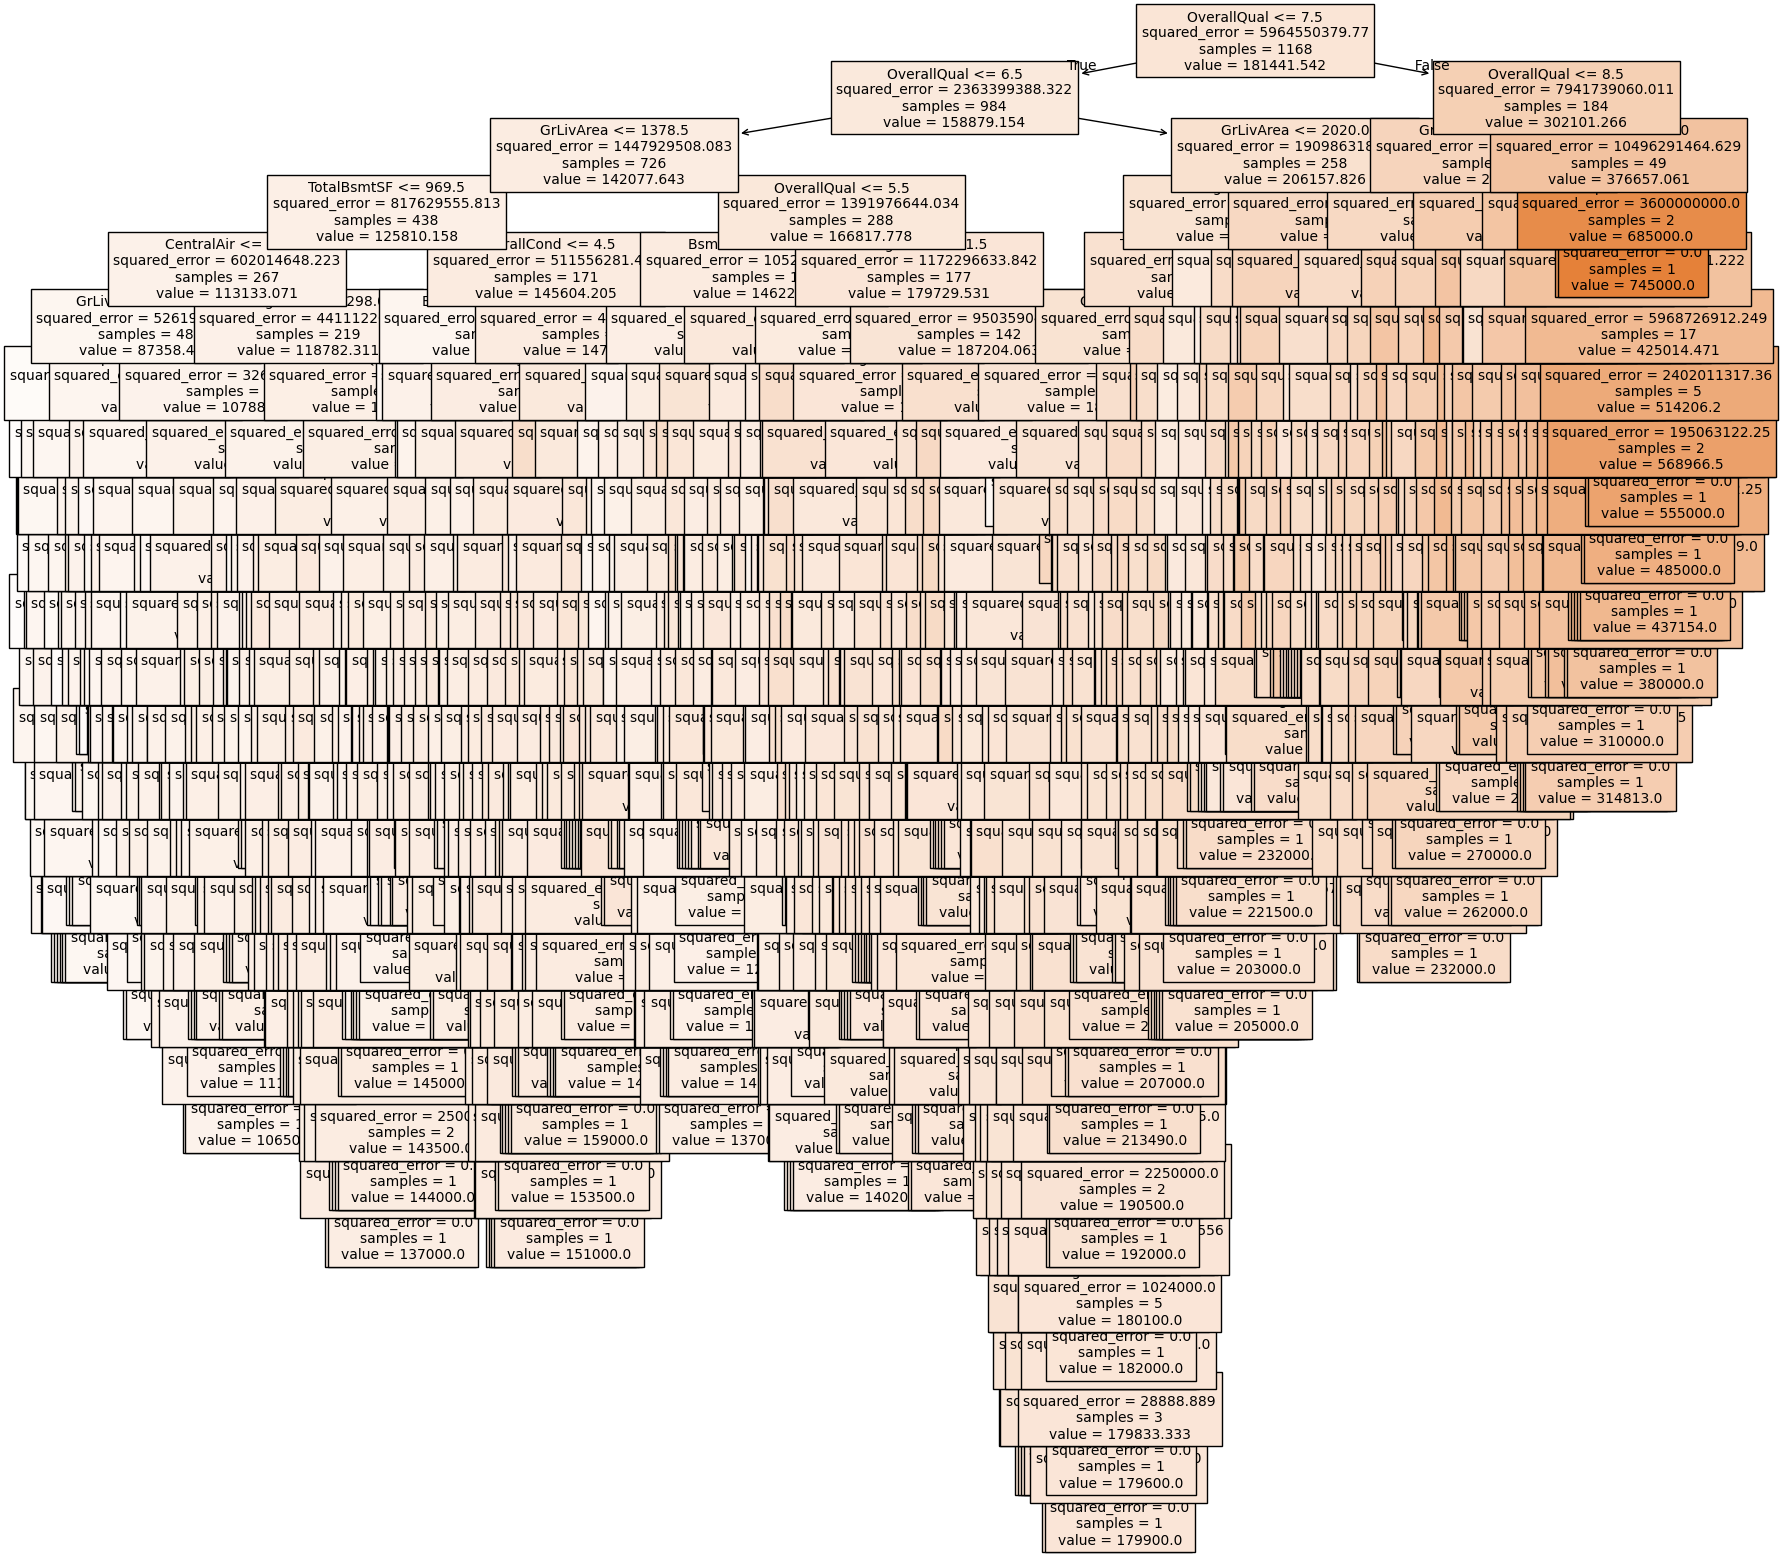

In [133]:
plt.figure(figsize=(20,20))
plot_tree(OneRegr.fit(X_train, y_train),filled=True,feature_names=X_train.columns,fontsize=10)

In [164]:
Regr = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=1, n_jobs=-1,oob_score=True,warm_start=True)
Regr.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_jobs=-1, oob_score=True,
                      random_state=1, warm_start=True)

In [165]:
Regr.score(X_test, y_test)

0.8930099950292573

Kết luận: với những dữ liệu mà quá nhiều feature, với nhiều feature mà ko ảnh hưởng qua lại lẫn nhau quá nhiều thì nên dùng random forest?